# Using `musif` in pro mode

This tutorial is intended for people that already have some programming skills. If you just want to try and explore musif, first check the [Getting started tutorial](./Tutorial.html).
You will also find guide for installation procedure and set-up there.

In [1]:
!pip install -e ../..

Obtaining file:///home/sapo/develop/musiF_tests/musif
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for musif (pyproject.toml) ... done
  Created wheel for musif: filename=musif-1.0.0-py3-none-any.whl size=1223 sha256=700659c6fde83db3252809f5e211956bf75d54713aa4c801b986b208d1008ead
  Stored in directory: /tmp/pip-ephem-wheel-cache-4jzxfv_g/wheels/08/60/07/6dafb023e08f6932483e74b4ad27d2d5b0cfc10920f98fe873
Successfully built musif
  Attempting uninstall: musif
    Found existing installation: musif 1.0.0
    Uninstalling musif-1.0.0:
      Successfully uninstalled musif-1.0.0


First, let's import musif. You may need to restart the notebook kernel here!

In [2]:
import musif
print(musif.__version__)

1.0.0


## Data

For starting, let's download [this](https://zenodo.org/record/4027957) dataset, which contains various pop-rock scores in MIDI format, from Eric Clapton to The Beatles. Uncompress it under a folder named `data` in the same directory as this notebook. Alternatively, just run the following cell:

In [3]:
import urllib.request
import zipfile
from pathlib import Path

data_dir = Path("data_poprock")
dataset_path = "dataset.zip"
urllib.request.urlretrieve("https://figshare.com/ndownloader/articles/5436031/versions/1", dataset_path)
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

## Create pre-cache hooks
Since`musif` was created with a strong focus on 18-th Century opera arias, there might be some elements in this dataset that are not fully supported by the parsing engine, or some aspect of the music that is not considered by the features.

First, let's focus on those notation elements that are not supported by our parsing engine. The best way to do this is by creating pre-cache hooks, i.e. pieces of code that are executed before the initialization of the cache system and, therefore, can alterate `music21` objects.

There are several ways to create these hooks. For more information refer to the [caching](./Caching.html) documentation page. Here, we'll create them using the class approach.

### Removing drums
Our pop-rock MIDI corpus contains one or more parts corresponding to drums or other percussion instruments.
Currently, `musif` is not able to handle such kind of notation and would throw errors about the score key signature.
For this reason, we are going to remove drum parts before starting the extraction.

Let's create a `RemoveDrums` class that finds every part that corresponds to a drum part and removes it from the data dictionary, so `musif` can extract the score peacefully.

In [4]:
# musif.extract.constants contains various constants useful to access the `data` dictionary
import musif.extract.constants as C

# the following list is specific to this dataset
drums_list = ['drumset', 'tambourine', 'drum', 'concert snare drum', 'hi-hat', 'automobile brake drums']

# a hook is any object that contains a `execute(cfg, data)` method
class RemoveDrums:
    def execute(cfg, data):
        # let's get the list of parts
        parts = list(data[C.DATA_FILTERED_PARTS])
        # C.DATA_SCORE is a music21.stream.Score object
        drums = [i for i in data[C.DATA_SCORE].parts if i._partName.split(',')[0].lower() in drums_list]
        # remove all the drums from the score
        data[C.DATA_SCORE].remove(drums)
        # reset the list of parts in the dictionary
        data[C.DATA_FILTERED_PARTS] = tuple([p for p in parts if p not in drums])
        # return the data
        return data

### Renaming similar parts
`musif` differentiate part features based on their name. For instance, if two parts have the name `Guitar`, it will merge all the notes in just one part. We decided to enforce this requirement by design.

For this reason, we must create a hook that renames all parts that have the same name in our internal data dictionary, so extraction will be run with names already altered.

In [5]:
class RenameSimilarParts:
    def execute(cfg, data):
        parts = list(data[C.DATA_FILTERED_PARTS])
        part_names = set()
        counter = 1
        for part in data[C.DATA_SCORE].parts:
            
            # If the part is already in part_names set, we must change its partName, Abbreviation and Id
            if part.partName in part_names:
                part.partName = part.partName + f'({counter})'
                part.partAbbreviation = part.partAbbreviation + f'({counter})'
                part.id = part.id+ f'({counter})'
                counter += 1
                part_names.add(part.partName)
            else:
                part_names.add(part.partName)
        # By altering the part object of music21, the change its already reflected also in the parts list.       
        data[C.DATA_FILTERED_PARTS] = tuple(parts)
        return data

## Create your own custom feature

Now, we are going to create a custom feature. Methods to create custom features are detailed in the [custom features](./Custom_features.html) documentation page. Briefly, there are two main ways to do it:

- as a module: like the stock `musif` features. If you have musif installed you can just copy one of the modules and adapt it to your taste, for instance, for instance [`musif.extract.features.ambitus`](https://github.com/DIDONEproject/musif/tree/main/musif/extract/features/ambitus) could be a good point of start
- as a class: we need to create a class that contains a `handler` sub-class that will run our calculations. This is the method we are going to show now, as it is more suitable for small modules and for a jupyter notebook.

First, let's create a class. In our case, we will create a dummy feature that calculates the number of beats for which the voice part is in silence over the total of beats of the song. Note that `musif` is actually already computing the opposite, i.e. the ratio of measures for which the voice parts is singing

Firts, let's import some musif utilities:

In [6]:
from musif.musicxml.tempo import get_number_of_beats
import musif.extract.constants as C
from musif.extract.features.core.constants import DATA_NOTES_AND_RESTS, DATA_MEASURES
from musif.extract.features.tempo.constants import TIME_SIGNATURE
from musif.extract.features.prefix import get_part_feature

In [ ]:
ARTIST = 'Artist'
TITLE = 'Title'
from musif.extract.constants import DATA_FILE

class file_name_feature:
    class file_name:
        def update_score_objects(
            score_data,
            parts_data,
            cfg,
            parts_features,
            score_features,
        ):
            """
            Gets title and artist from the file name.
            """
            file_name = basename(score_data[DATA_FILE])
            name = file_name.split('.')[:-1]
            if '_' in name:
                name = name.split('_')
                title = name[0]
                artist = ""
            else:
                title = "".join(name)
                artist = ""
            artist = name[0]
            title = name[1]
                
            score_features.update(
                {
                    ARTIST: artist,
                    TITLE: title,
                }
            )

        def update_part_objects(
            score_data, part_data, cfg, part_features
        ):
            pass


Considering a `musif` stock feature like `ambitus`, `musif.extract.features` is the feature package while `musif.extract.features.ambitus` is a feature module.

Here, since we are working inside a jupyter notebook, we will substitute the package containing the features with a  class named `custom_feature_package`, so that the hirarchy is `feature package > feature module > handler`. Inside the feature package there can be multiple features.

We will name our feature `voice_silence_beats`. This will also be the feature module name. It must contain an object called `handler`, which in turn must contain two methods: `update_part_objects` and `update_score_objects`.

In the case of our custom feature, `custom_feature_package`, `voice_silence_beats`, and `handler` are all classes, but they could also be packages and modules.

In [7]:
VOICE_SILENCE_BEATS = 'voice_silence_beats'

class custom_feature_package:
    class voice_silence_beats:
        """
        This feature calculates the number of beats the voice is in silence over the total of the song
        """
        class handler:
            def update_part_objects(
                score_data: dict = None,
                part_data: list = None,
                cfg: object = None,
                parts_features: list = None,
            ):
                # We will extract the number of beats that voice parts are in silence and 
                # divide it by the total number of beats. First we need to filter only voice/singer parts. 
                if part_data[C.DATA_FAMILY] == 'voice':
                    rests = [i for i in part_data[DATA_NOTES_AND_RESTS] if i.isRest]
                    rests_duration = sum([i.quarterLength for i in rests])
                    number_of_measures = score_data[DATA_MEASURES]
                    total_beats = get_number_of_beats(score_data[TIME_SIGNATURE]) * number_of_measures
                    voice_silence = rests_duration / total_beats
                    parts_features[get_part_feature(part_data[C.DATA_PART_ABBREVIATION], VOICE_SILENCE_BEATS)] = voice_silence
                else:
                    pass
            def update_score_objects(
                score_data: dict = None,
                parts_data: list = None,
                cfg: object = None,
                parts_features: list = None,
                score_features: dict = None,
            ):
                # Finally, we need to add the data to score_features, 
                # the dictionary where all final info is stored. 
                # Otherwise it will not be reflected in the final dataframe.
                features = {}
                for i, part_data in enumerate(parts_data):
                    if part_data[C.DATA_FAMILY] == 'voice':
                        part_abbreviation = part_data[C.DATA_PART_ABBREVIATION]
                        feature_name = get_part_feature(part_abbreviation, VOICE_SILENCE_BEATS)
                        features[feature_name]=parts_features[i][get_part_feature(part_abbreviation, VOICE_SILENCE_BEATS)]
                score_features.update(features)

## Configuration

Let's create a configuration for our experiment. For more information, see the [Getting started tutorial](./Tutorial.html).

Here, we will point your attention towards the following options:
1. `features`: we added `voice_silence_beats`, our custom feature
2. `feature_module_addresses`: we added `custom_feature_package`
3. `precache_hooks`: we added our hooks `RemoveDrums` and `RenameSimilarParts`, but it can also contains strings representing modules or packages that can be imported by Python. similarly to `feature_modules_addresses`

In [8]:
from musif.config import ExtractConfiguration

In [9]:
config = ExtractConfiguration(
    None,
    basic_modules = ['scoring', 'file_name_generic'],
    musescore_dir="data_poprock",
    features = ["core", "ambitus", "interval", "tempo", 
            "density", "texture", "lyrics", "scale", 
            "key", "dynamics", "rhythm", 
            "voice_silence_beats"], # Remember to add your custom feature here
    feature_modules_addresses = ["musif.extract.features", 
    file_name_feature, custom_feature], # We can pass our custom_feature here directly as a class, or the folder that contains it if its a module.
    precache_hooks = [RemoveDrums, RenameSimilarParts] # Classes for the hooks that are defined before are passed here. You can also pass floder direction for the modules if so.
)

## Feature extraction

Now that we have our configuration, we pass it to the `FeaturesExtractor` constructor:

In [10]:
from musif.extract.extract import FeaturesExtractor

extractor = FeaturesExtractor(config)

Before starting the extraction, we also need to tell MuseScore the type of files it should look for. In this case, we want it looks for files with extension `'.mid'`. By default, it would look for `.mscx` files, so we need to change it:

In [11]:
import musif.musescore.constants as musescore_c
musescore_c.MUSESCORE_FILE_EXTENSION = '.mid'

Now, we can start the extraction using the method `extract`. It will return a `dataframe`:

In [12]:
df = extractor.extract()

  0%|          | 0/25 [00:00<?, ?it/s]/home/sapo/develop/musiF_tests/musif/docs/source/.venv/lib/python3.11/site-packages/music21/musicxml/xmlToM21.py:1730: MusicXMLWarning: 24 does not map to a valid instrument!
  warnings.warn(MusicXMLWarning(mpe))
  4%|▍         | 1/25 [00:07<03:08,  7.86s/it]/home/sapo/develop/musiF_tests/musif/docs/source/.venv/lib/python3.11/site-packages/music21/musicxml/xmlToM21.py:1730: MusicXMLWarning: 51 does not map to a valid instrument!
  warnings.warn(MusicXMLWarning(mpe))
 20%|██        | 5/25 [00:43<03:13,  9.69s/it]/home/sapo/develop/musiF_tests/musif/docs/source/.venv/lib/python3.11/site-packages/music21/musicxml/xmlToM21.py:1730: MusicXMLWarning: 11 does not map to a valid instrument!
  warnings.warn(MusicXMLWarning(mpe))
 32%|███▏      | 8/25 [01:11<02:41,  9.50s/it]/home/sapo/develop/musiF_tests/musif/docs/source/.venv/lib/python3.11/site-packages/music21/musicxml/xmlToM21.py:1730: MusicXMLWarning: 39 does not map to a valid instrument!
  warnings

In [13]:
# To show the dataframe in a Jupyter notebook, just use it as last instruction of the cell, like this:
df

,Artist,FamilyBr_Density,FamilyBr_Notes,FamilyBr_NotesMean,FamilyBr_NumberOfFilteredParts,FamilyBr_NumberOfParts,FamilyBr_SoundingDensity,FamilyBr_SoundingMeasures,FamilyBr_SoundingMeasuresMean,FamilyElectric_Density,...,SoundVo_TrimmedIntervallicMean,SoundVo_TrimmedIntervallicStd,Tempo,TempoGrouped1,TempoGrouped2,TimeSignature,TimeSignatureGrouped,Title,Voices,WindowId
0,Enya,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.002193,...,0.0,1.822193,<NA>,<NA>,None,4/4,simple duple,OrinocoFlow,"sop,sop,s,vo,a",0
1,EricClapton,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.635088,...,<NA>,<NA>,<NA>,<NA>,None,4/4,simple duple,Born_Under_a_Bad_Sign,"alt,bar",0
2,EricClapton,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.508929,...,<NA>,<NA>,<NA>,<NA>,None,4/4,simple duple,Cocaine,,0
3,EricClapton,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.46,...,<NA>,<NA>,<NA>,<NA>,None,4/4,simple duple,I_Shot_the_Sheriff,sop,0
4,EricClapton,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.289352,...,<NA>,<NA>,<NA>,<NA>,None,4/4,simple duple,Layla,ten,0
5,Queen,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.391762,...,<NA>,<NA>,<NA>,<NA>,None,4/4,simple duple,Another_One_Bites_the_Dust,,0
6,Queen,0.210744,102,102.0,1,1,1.416667,36,36.0,0.444215,...,-0.25,2.890358,<NA>,<NA>,None,2/4,simple duple,Bohemian_Rhapsody,"alt,vo",0
7,Queen,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.39221,...,<NA>,<NA>,<NA>,<NA>,None,4/4,simple duple,Play_the_Game,sop,0
8,Queen,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.399246,...,<NA>,<NA>,<NA>,<NA>,None,4/4,simple duple,Under_Pressure,a,0
9,Queen,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.434109,...,0.0,0.0,<NA>,<NA>,None,3/8,compound duple,We_Are_The_Champions,vo,0


## Post-processing

We will now postprocess the data, again, see the [Getting started tutorial](./Tutorial.html) for more info.

In [14]:
from musif.process.processor import DataProcessor

processed_df = DataProcessor(df, None).process().data

# with `.shape` you can see the number of rows and columns of the dataframe
processed_df.shape


Processing DataFrame...

Preprocessing data...

Deleting not useful columns...
Replacing NaN values in selected columns


(25, 9866)

As you see, the columns are now less than before!

Let's try to remove `NaN` (elements that should be number but that cannot be expressed, e.g. the division $0/0$). To do this, we'll use the [`dropna` method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html?highlight=dropna#pandas.DataFrame.dropna) of the `pandas.DataFrame` object.

In [15]:
processed_df.dropna(axis=1, inplace=True)
processed_df.shape

(25, 203)

## Visualization

We will now visualize the 25 songs contained in the dataset using Linear Discriminant Analysis (LDA). Note that LDA is a supervised method, so a leave-one-out cross-validation would be needed to properly monito overfitting. However, for the purpose of this tutoria, we will limit to showcase an overfitted model.

For this visualization, you will need to install `scikit-learn` and `seaborn`. After having installed them, remember to restart the kernel of the notebook!

In [16]:
!pip install scikit-learn seaborn

/home/sapo/develop/musiF_tests/musif/docs/source/.venv/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 43  44  49  50  64  65  66  67  68 109 110 111 112 113 114 115 116 117
 118 119 120 164 166 167 169] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/sapo/develop/musiF_tests/musif/docs/source/.venv/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


<AxesSubplot: >

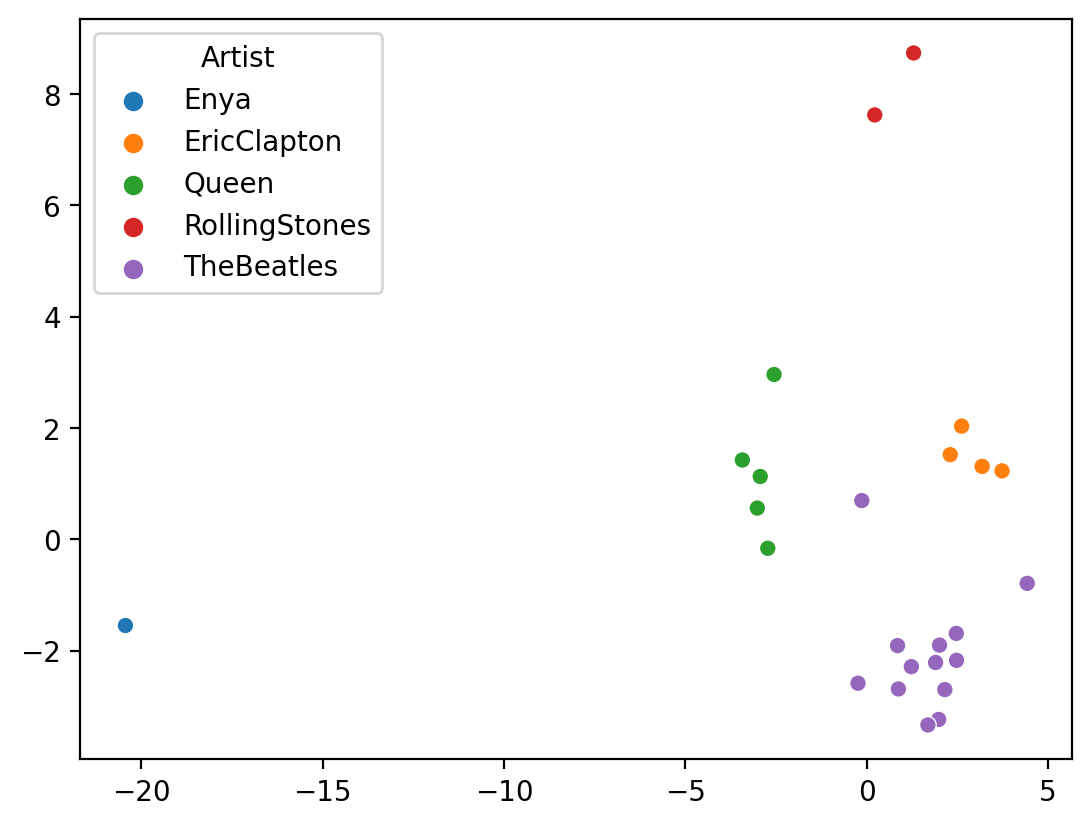

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectPercentile
from seaborn import scatterplot

target = processed_df['Artist']
data = processed_df.drop(columns=['Id', 'WindowId']).select_dtypes([int, float])
data = make_pipeline(StandardScaler(), 
                     SelectPercentile(percentile=10),
                     LDA(n_components=2, solver='svd')).fit_transform(data, target)
scatterplot(x=data[:, 0], y=data[:, 1], hue=target)
